In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pltx
import seaborn as sns
import pystan
import pickle
import scipy.cluster.hierarchy as sch
import copy
import os

# 🔥 Fix: Add utils/ directory where vb_stan.py and sub_fun.py are located
sys.path.append("../utils")  # Ensure utils is in module search path

import vb_stan as vbfun
import sub_fun as sf

# import ./data_file.py file from current directory
try:
    from data_file import *
except ModuleNotFoundError as e:
    print(f"❌ Could not import data_file as module, trying another way...")
    try:
        exec(open('./data_file.py').read())  # Execute the script
    except Exception as e:
        print(f"❌ Could not import data_file.py")


import os

# 1. Read config_mode.txt
config_file = "config_mode.txt"
if os.path.exists(config_file):
    with open(config_file, "r") as f:
        lines = f.read().splitlines()
        data = lines[0].strip() if len(lines) > 0 else "original"
        setting = int(lines[1]) if len(lines) > 1 else 1


# 2. Set plots folder based on config
if data == "original" and setting == 1: 
    figfol = "./plots1/"
elif data == "original" and setting == 2:
    figfol = "./plots2/"
elif data == "new" and setting == 2: 
    figfol = "./plots3/"

if not os.path.exists(figfol):
    os.makedirs(figfol)
    print(f"✅ Created folder: {figfol}")
else:
    print(f"📂 Folder already exists: {figfol}")

if data == "original": 
    data_path = "data_op"
else: 
    data_path = "data_new"
    
# Update plot settings
plt.rcParams.update(plt.rcParamsDefault)
params = {
    'legend.fontsize': 12,
    'font.weight': 'bold',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 12,
    'figure.dpi': 200,
    'ytick.labelsize': 12
}
plt.rcParams.update(params)

%matplotlib inline


/dss/dsshome1/09/ra64nef3/.conda/envs/vim/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


📂 Folder already exists: ./plots1/


In [2]:
# Call the output from the fitted model:
import glob
import pickle
import os


# Define folder path
folname = '../src/'
#fname_best = '18_52_model_nb_cvtest.pkl' #original data ndc#
#fname_best = '30_61_model_nb_cvtest.pkl' #new data nc 
fname_best = '30_68_model_nb_cvtest.pkl' #original data dc 
# Load fitted model output
with open(os.path.join(folname, fname_best), 'rb') as f:
    [holdout_mask, llpd, n_test, l, m_seed, sp_mean, sp_var, h_prop, uid, nsample_o, Yte_fit, cv_test] = pickle.load(f)

# Construct filenames using uid and m_seed
fname_ot = os.path.join(folname, f"{uid}_{m_seed}_model_nb.pkl")
sample_fname = os.path.join(folname, f"{uid}_{m_seed}_sample_model_nb_cvtest.pkl")


# Load results
with open(fname_ot, 'rb') as f:
    results = pickle.load(f)

#Load sample model output
with open(sample_fname, 'rb') as f:
   [Yte_sample, Yte_cv] = pickle.load(f)


parma_mean  = dict(vbfun.vb_extract_mean(results))

../utils/vb_stan.py:57: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty(shape)) for name, shape in param_shapes.items()])


In [3]:
import pandas as pd
import numpy as np

# Load taxonomy file
tax_name = pd.read_csv(f'../data/{data_path}/species_tax.csv')
tax_name = tax_name.rename(columns={'Unnamed: 0': 'OTU'})
tax_name = tax_name[1:]  # Drop header row if repeated
tax_name.insert(0, 'Id', tax_name['OTU'].str[3:])
tax_name.columns.values[1] = 'Label'
tax_name.to_csv('node_otu.csv', index=False)
tax_name[['Id']] = tax_name[['Id']].astype(np.int64)
tax_name = tax_name.replace(pd.NA, 'Empty').replace(np.nan, 'Empty')

# Extract most specific taxonomy level as Name
temx = tax_name.iloc[:, :8].replace('Empty', '')
species_name = []
for i in range(temx.shape[0]):
    a = temx.iloc[i].values
    for j in range(len(a)-1, -1, -1):
        if len(a[j]) > 0:
            species_name.append(temx.columns[j][0].lower() + '_' + a[j])
            break
tax_name['Name'] = np.array(species_name)

# Add Abundance (assumes Y is defined)
tax_name['Abundance'] = Y.sum(axis=0)

# -------------------------------
# Use different logic based on `data` flag
# -------------------------------

tem = pd.read_csv(f'../data/{data_path}/species_tax_anot.amended.csv').iloc[:, [1, 12]]
tax_name = tax_name.merge(tem, on='Label')
tax_name = tax_name.rename(columns={"Ecologically_relevant_classification_aggregated": "ECR"})

# Group rare ECR categories into 'Other'
ind_var = tax_name['ECR'].values
vals, counts = np.unique(ind_var, return_counts=True)
sorted_vals = vals[(-counts).argsort()]
common_vals = sorted_vals[:np.sum(counts > 10)]
rare_vals = np.setdiff1d(vals, common_vals)
tax_name['ECR'] = np.where(np.isin(ind_var, rare_vals), 'Other', ind_var)

# ✅ Show summary
print("✅ Taxonomic annotation completed.")
print("Top ECR categories:\n", tax_name['ECR'].value_counts().head())


✅ Taxonomic annotation completed.
Top ECR categories:
 SAR11 clade                   232
Alteromonadales               120
Flavobacteriales              101
Other                          84
Chloroplast (unclassified)     80
Name: ECR, dtype: int64


In [4]:
selected_species = list(np.unique(tax_name['ECR']))
#selected_species.remove('Other')
selected_species_index = tax_name['ECR'].isin(selected_species).values
#species_col_dict = dict(zip(selected_species,distinct_colp[:len(selected_species)]))

In [5]:
## Species- species interactiion matrix estimate 
cov_mat = np.matmul(parma_mean['L_sp'],parma_mean['L_i'].T)
cov_mat  = cov_mat  #cov_mat.max() - cov_mat
cov_mat = (cov_mat + cov_mat.T)/2
np.fill_diagonal(cov_mat,0)

selected_species_index = tax_name['ECR'].isin(selected_species).values
dist_pos = copy.copy(cov_mat[selected_species_index][:,selected_species_index])
dist_neg = copy.copy(cov_mat[selected_species_index][:,selected_species_index])
for i in range(dist_pos.shape[0]):
    tem = dist_pos[i].argsort()
    dist_pos[i,tem[:-5]] = 0. 
    dist_neg[i,tem[5:]] = 0.
    
dist_neg = dist_neg*(-1.0)
    

In [6]:
tax_name3 = copy.copy(tax_name)
tax_name3['Id'] =  tax_name3['Label']
tax_name3 = tax_name3[selected_species_index]
ECR = np.unique(tax_name3['ECR'])

temp_pos = np.zeros((len(ECR),len(ECR)))
for i in range(len(ECR)):
    for j in range(len(ECR)):
        r_ind = tax_name3['ECR'] == ECR[i]
        c_ind = tax_name3['ECR'] == ECR[j]
        temp_pos[i,j] = np.sum(dist_pos[r_ind,][:,c_ind]>0)
temp_pos  = temp_pos. astype(np.int)    
temp_pos =  temp_pos + temp_pos.T
np.fill_diagonal(temp_pos, np.diag(temp_pos)/2)
# temp_pos[np.triu_indices(len(ECR),1)] = 0
# np.sum(temp_pos)/5 # sanity check
temp_pos = pd.DataFrame(temp_pos)
temp_pos.index = [i.replace(' (', '\n(') for i in ECR] 
temp_pos.columns = [i.replace(' (', '\n(') for i in ECR] 




/dss/dsshome1/09/ra64nef3/.conda/envs/vim/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == "":


In [7]:
temp_neg = np.zeros((len(ECR),len(ECR)))
for i in range(len(ECR)):
    for j in range(len(ECR)):
        r_ind = tax_name3['ECR'] == ECR[i]
        c_ind = tax_name3['ECR'] == ECR[j]
        temp_neg[i,j] = np.sum(dist_neg[r_ind,][:,c_ind]>0)
temp_neg  = temp_neg. astype(np.int)    
temp_neg =  temp_neg + temp_neg.T
np.fill_diagonal(temp_neg, np.diag(temp_neg)/2)
#temp_neg[np.triu_indices(len(ECR))] = 0

temp_neg = pd.DataFrame(temp_neg)
temp_neg.index = [i.replace(' (', '\n(') for i in ECR] 
temp_neg.columns = [i.replace(' (', '\n(') for i in ECR] 



/dss/dsshome1/09/ra64nef3/.conda/envs/vim/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


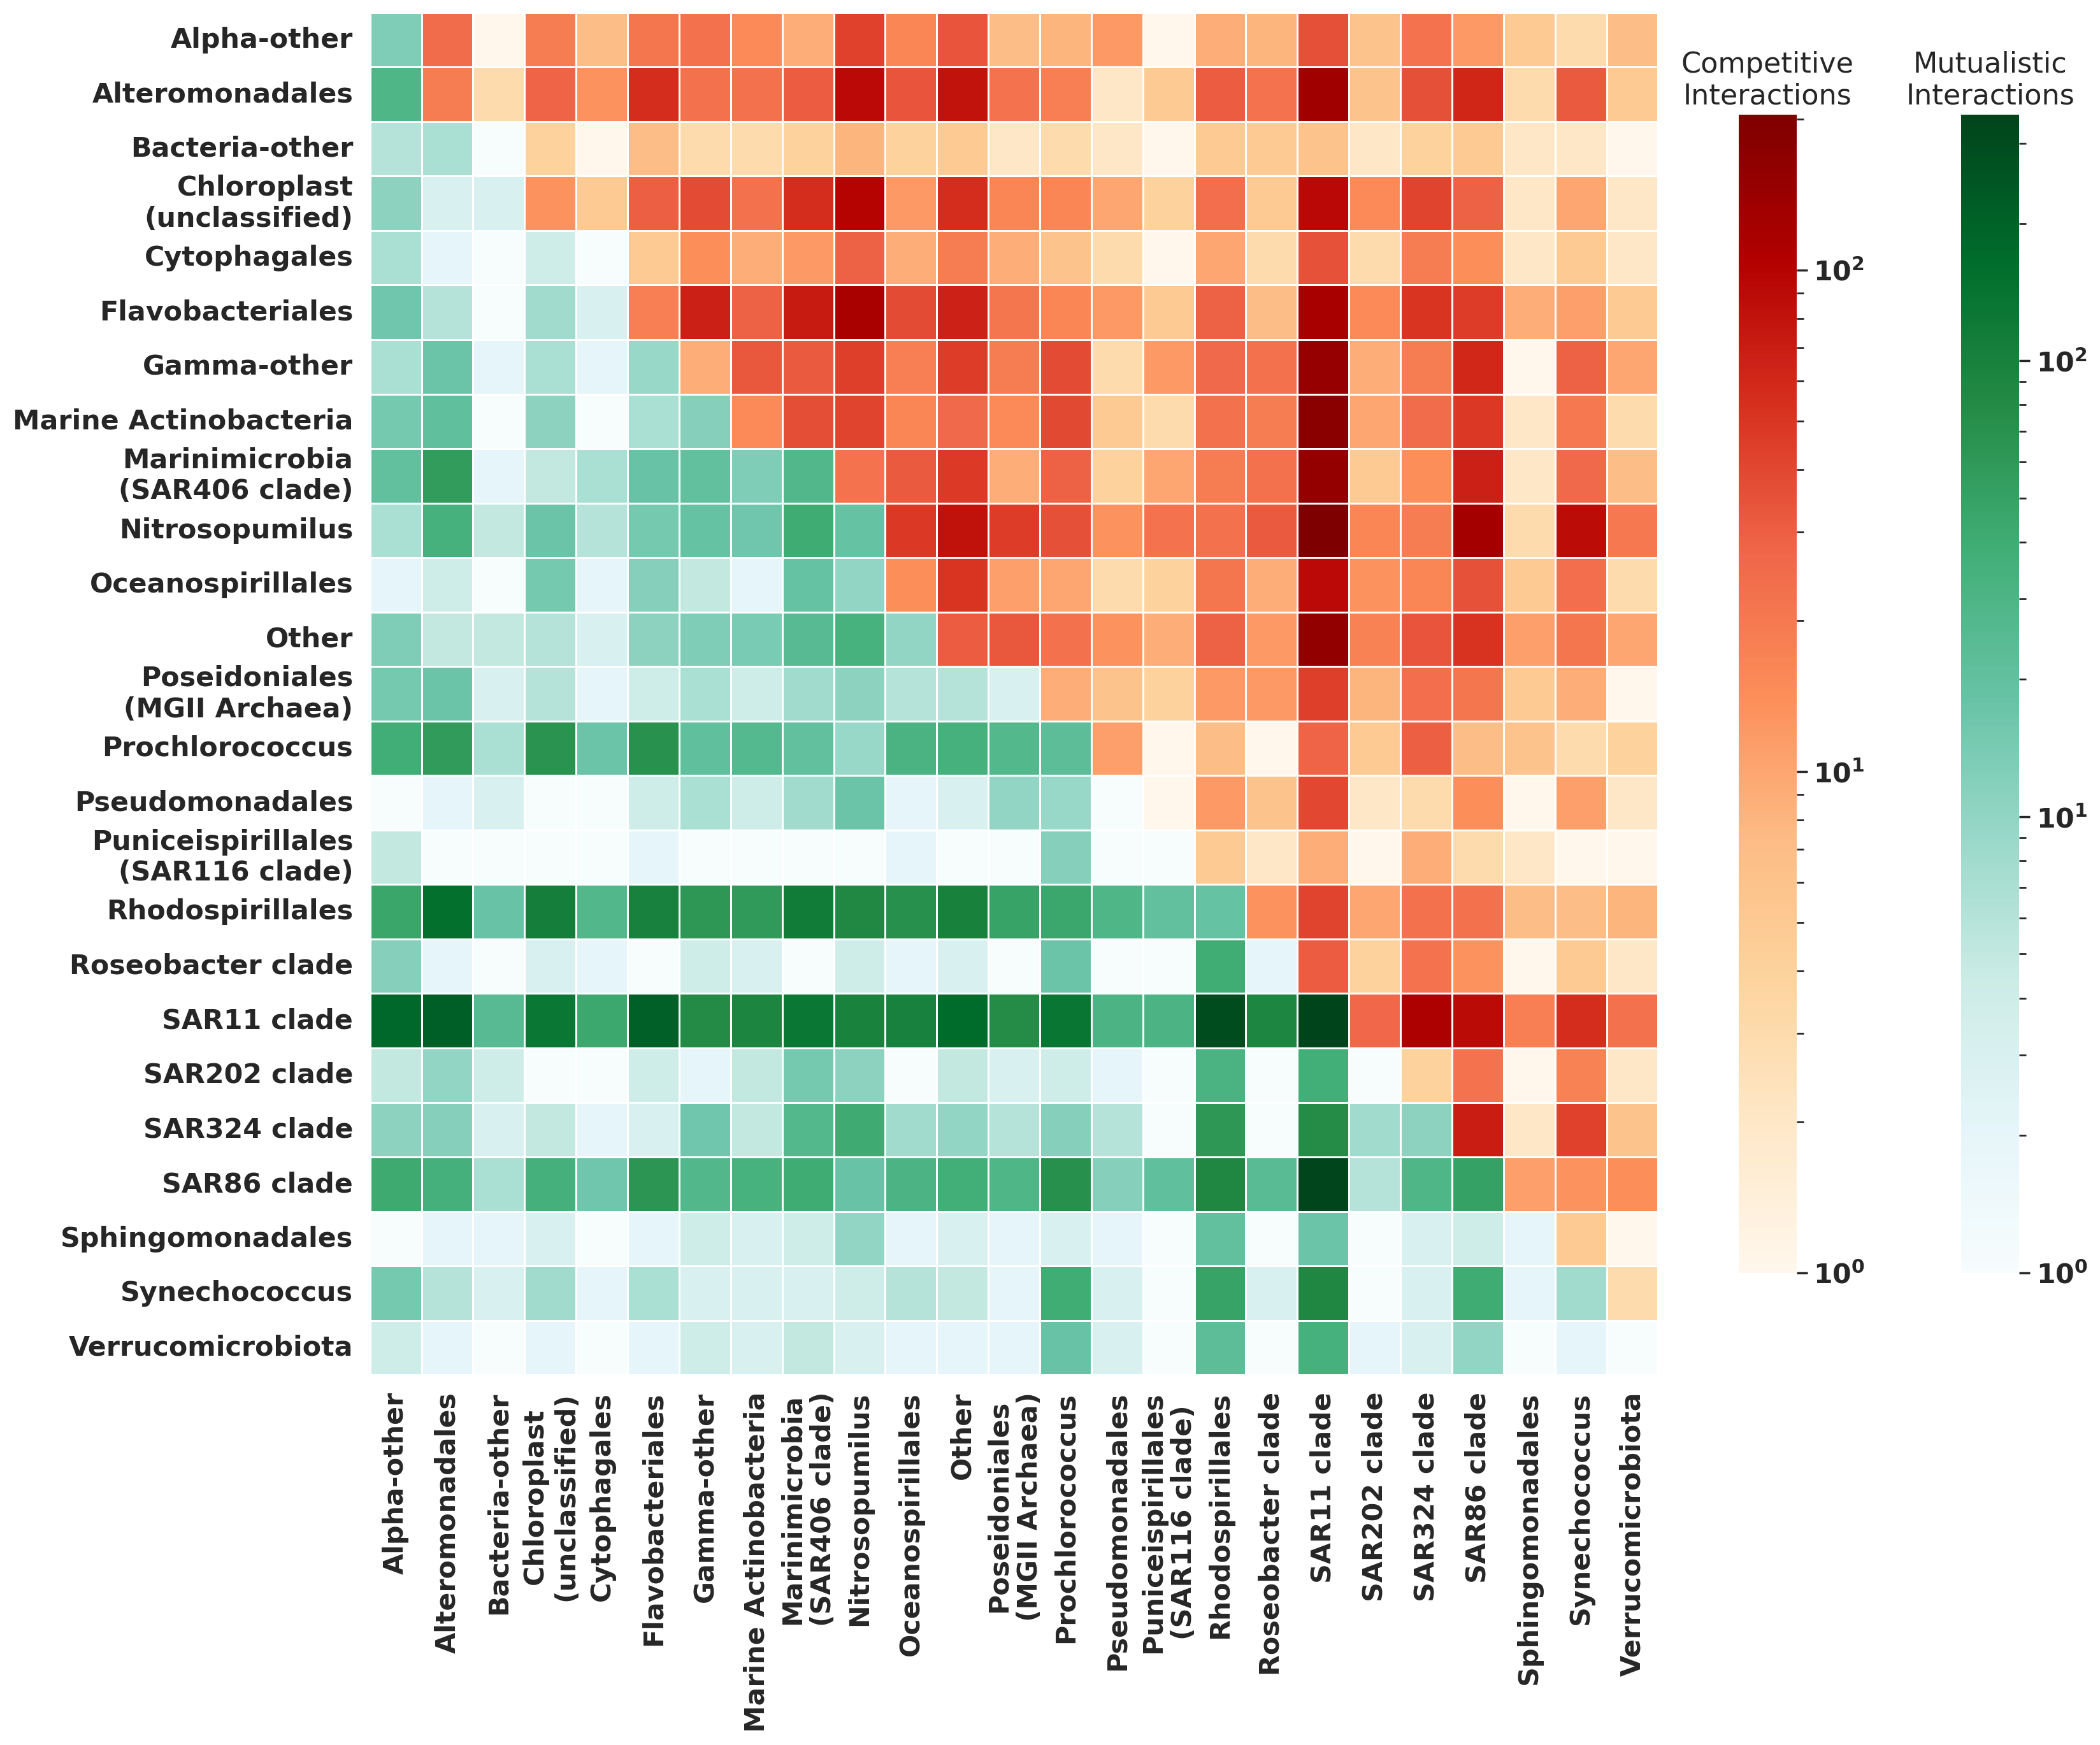

In [8]:
mask1 = np.zeros(temp_pos.shape)
mask1[np.triu_indices(len(ECR),0)] = True

mask2 = np.zeros(temp_pos.shape)
mask2[np.tril_indices(len(ECR),0)] = True
for i in range(temp_pos.shape[0]):
    if temp_pos.iloc[i,i] >= temp_neg.iloc[i,i]:
        mask1[i,i] = False
    else:
        mask2[i,i] = False

sns.set(font_scale=1.4)
from matplotlib.colors import LogNorm, Normalize

f, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(temp_pos+1,annot=False,   mask=mask1,vmin=1, norm=LogNorm(),   vmax=600, square=False,\
                annot_kws={"fontsize": 18}, cbar = True, cbar_kws = {'orientation':'vertical',"shrink": .85, "pad":-.01},\
                fmt='', ax = ax, cmap = 'BuGn',linewidths=.5)
sns.heatmap(temp_neg+1,annot=False,   mask=mask2,vmin=1,norm=LogNorm(),    vmax=600, square=False,\
                annot_kws={"fontsize": 18}, cbar = True, cbar_kws = {'orientation':'vertical', "shrink": .85},\
                fmt='', ax = ax, cmap = 'OrRd',linewidths=.5)
cbar0 = ax.collections[0].colorbar
cbar1 = ax.collections[1].colorbar
cbar0.ax.set_title('Mutualistic\nInteractions',fontsize=16)
cbar1.ax.set_title('Competitive\nInteractions',fontsize=16)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.yaxis.label.set_size(20)
f.tight_layout()
f.savefig(figfol + 'temp.png')